## Background

Zillow’s Zestimate home valuation has shaken up the U.S. real estate industry since first released 11 years ago.

A home is often the largest and most expensive purchase a person makes in his or her lifetime. Ensuring homeowners have a trusted way to monitor this asset is incredibly important. The Zestimate was created to give consumers as much information as possible about homes and the housing market, marking the first time consumers had access to this type of home value information at no cost.

“Zestimates” are estimated home values based on 7.5 million statistical and machine learning models that analyze hundreds of data points on each property. And, by continually improving the median margin of error (from 14% at the onset to 5% today), Zillow has since become established as one of the largest, most trusted marketplaces for real estate information in the U.S. and a leading example of impactful machine learning.

### Objective:

Build a model to improve the Zestimate residual error. 

### Client

In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import confusion_matrix,accuracy_score
import re
color = sns.color_palette()
import datetime
from catboost import CatBoostRegressor

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999


ModuleNotFoundError: No module named 'tqdm'

#### Reading the dataset

In [12]:
train=pd.read_csv('C:/Users/Lenovo/Downloads/all/train_2016_v2.csv')
properties=pd.read_csv('C:/Users/Lenovo/Downloads/all/properties_2016.csv')
sample=pd.read_csv('C:/Users/Lenovo/Downloads/all/sample_submission.csv')
#, parse_dates=['transactiondate']

C:\Users\Lenovo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:

for c, dtype in zip(properties.columns, properties.dtypes):
    if dtype == np.float64:
        properties[c] = properties[c].astype(np.float32)
        
train_merge = train.merge(properties, how='left', on='parcelid')

### Data wrangling:

In [14]:
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 60 columns):
parcelid                        90275 non-null int64
logerror                        90275 non-null float64
transactiondate                 90275 non-null object
airconditioningtypeid           28781 non-null float32
architecturalstyletypeid        261 non-null float32
basementsqft                    43 non-null float32
bathroomcnt                     90275 non-null float32
bedroomcnt                      90275 non-null float32
buildingclasstypeid             16 non-null float32
buildingqualitytypeid           57364 non-null float32
calculatedbathnbr               89093 non-null float32
decktypeid                      658 non-null float32
finishedfloor1squarefeet        6856 non-null float32
calculatedfinishedsquarefeet    89614 non-null float32
finishedsquarefeet12            85596 non-null float32
finishedsquarefeet13            33 non-null float32
finishedsquarefeet15        

It looks like lot of columns has misssing value. We need to do more investigation on whether to retain the columns or discard them.

### Data wrangling for  missing data fields

In [15]:
missing_perc_thresh = 0.99
exclude_missing = []
num_rows = train_merge.shape[0]
for c in train_merge.columns:
    num_missing = train_merge[c].isnull().sum()
    if num_missing == 0:
        continue
    missing_frac = num_missing / float(num_rows)
    if missing_frac > missing_perc_thresh:
        exclude_missing.append(c)
print("We exclude: %s" % exclude_missing)
print(len(exclude_missing))

We exclude: ['architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedsquarefeet13', 'finishedsquarefeet6', 'storytypeid', 'typeconstructiontypeid', 'yardbuildingsqft26', 'fireplaceflag']
10


Four columns have 99.9% missing values.

Let's start off by potentially removing some 'redundant' variables and then some others ones which are 'easy' to fix

In [16]:
#'calculatedfinishedsquarefeet' has the fewest missing values so lets remove the others, note also that except for 'finishedsquarefeet12' the rest have large amount of missing values anyways. 
dropcols = ['finishedsquarefeet12', 'finishedsquarefeet15']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions, lets remove finishedsquarefeet50 as it has more missing values
dropcols.append('finishedsquarefeet50')

#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')

In [17]:
#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = train_merge.hashottuborspa.isnull()
train_merge.loc[index,'hashottuborspa'] = "None"

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field - these two fields should have the same information I assume?
print(train_merge.hashottuborspa.value_counts())
print(train_merge.pooltypeid10.value_counts())


#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = train_merge.pooltypeid2.isnull()
train_merge.loc[index,'pooltypeid2'] = 0

index = train_merge.pooltypeid7.isnull()
train_merge.loc[index,'pooltypeid7'] = 0

index = train_merge.poolcnt.isnull()
train_merge.loc[index,'poolcnt'] = 0

index = train_merge.fireplacecnt.isnull()
train_merge.loc[index,'fireplacecnt'] = 0


None    87910
True     2365
Name: hashottuborspa, dtype: int64
1.0    1161
Name: pooltypeid10, dtype: int64


In [18]:
#Theres more missing values in the 'poolsizesum' then in 'poolcnt', Let's fill in median values for poolsizesum where pool count is >0 and missing. I think this is sensible assumption as residential pool sizes are fairly standard size I guess in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable based on the heat map so imputing with the median hopefully won't cause too much of an issue
print(train_merge.poolsizesum.isnull().sum())
print(train_merge.poolcnt.value_counts())

#Fill in those properties that have a pool with median pool value
poolsizesum_median = train_merge.loc[train_merge['poolcnt'] > 0, 'poolsizesum'].median()
train_merge.loc[(train_merge['poolcnt'] > 0) & (train_merge['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
train_merge.loc[(train_merge['poolcnt'] == 0), 'poolsizesum'] = 0



89306
0.0    72374
1.0    17901
Name: poolcnt, dtype: int64


Lets get statistical summary for the categorical or string variables:

In [20]:
describe = train_merge.describe(include=['O']).transpose().reset_index()
describe.columns = ['Categorical Feature','count', 'unique', 'top', 'freq']
describe

,Categorical Feature,count,unique,top,freq
0,transactiondate,90275,352,2016-07-29,910
1,hashottuborspa,90275,2,None,87910
2,propertycountylandusecode,90274,77,0100,30846
3,propertyzoningdesc,58313,1996,LAR1,7678
4,fireplaceflag,222,1,True,222
5,taxdelinquencyflag,1783,1,Y,1783


The correlation of the target variable with the given set of variables are low overall.

There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [21]:
# exclude where we only have one unique value 
exclude_unique = []
for c in train_merge.columns:
    num_uniques = len(train_merge[c].unique())
    if train_merge[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print("We exclude: %s" % exclude_unique)
print(len(exclude_unique))

We exclude: ['buildingclasstypeid', 'decktypeid', 'pooltypeid10', 'storytypeid', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag']
7


### Define training features

In [22]:
exclude_other = ['parcelid', 'logerror','transaction_month'] 
exclude_other.append('propertyzoningdesc')
#exclude_other.append('propertyzoningdesc')
train_features = []
for c in train_merge.columns:
    if c not in exclude_missing \
       and c not in exclude_other \
        and c not in exclude_unique and train_merge[c].dtype != 'object':
        train_features.append(c)
print("We use these for training: %s" % train_features)
print(len(train_features))

We use these for training: ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet15', 'finishedsquarefeet50', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'censustractandblock']
41


### Define training features which are categorical

In [23]:
cat_feature_inds = []
cat_unique_thresh = 1000
for i, c in enumerate(train_features):
     if train_merge[c].dtype=='object':
        cat_feature_inds.append(i)       
print("Cat features are: %s" % [train_features[ind] for ind in cat_feature_inds])

Cat features are: []


lets analyze features with moderate correlation.

C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Lenovo\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


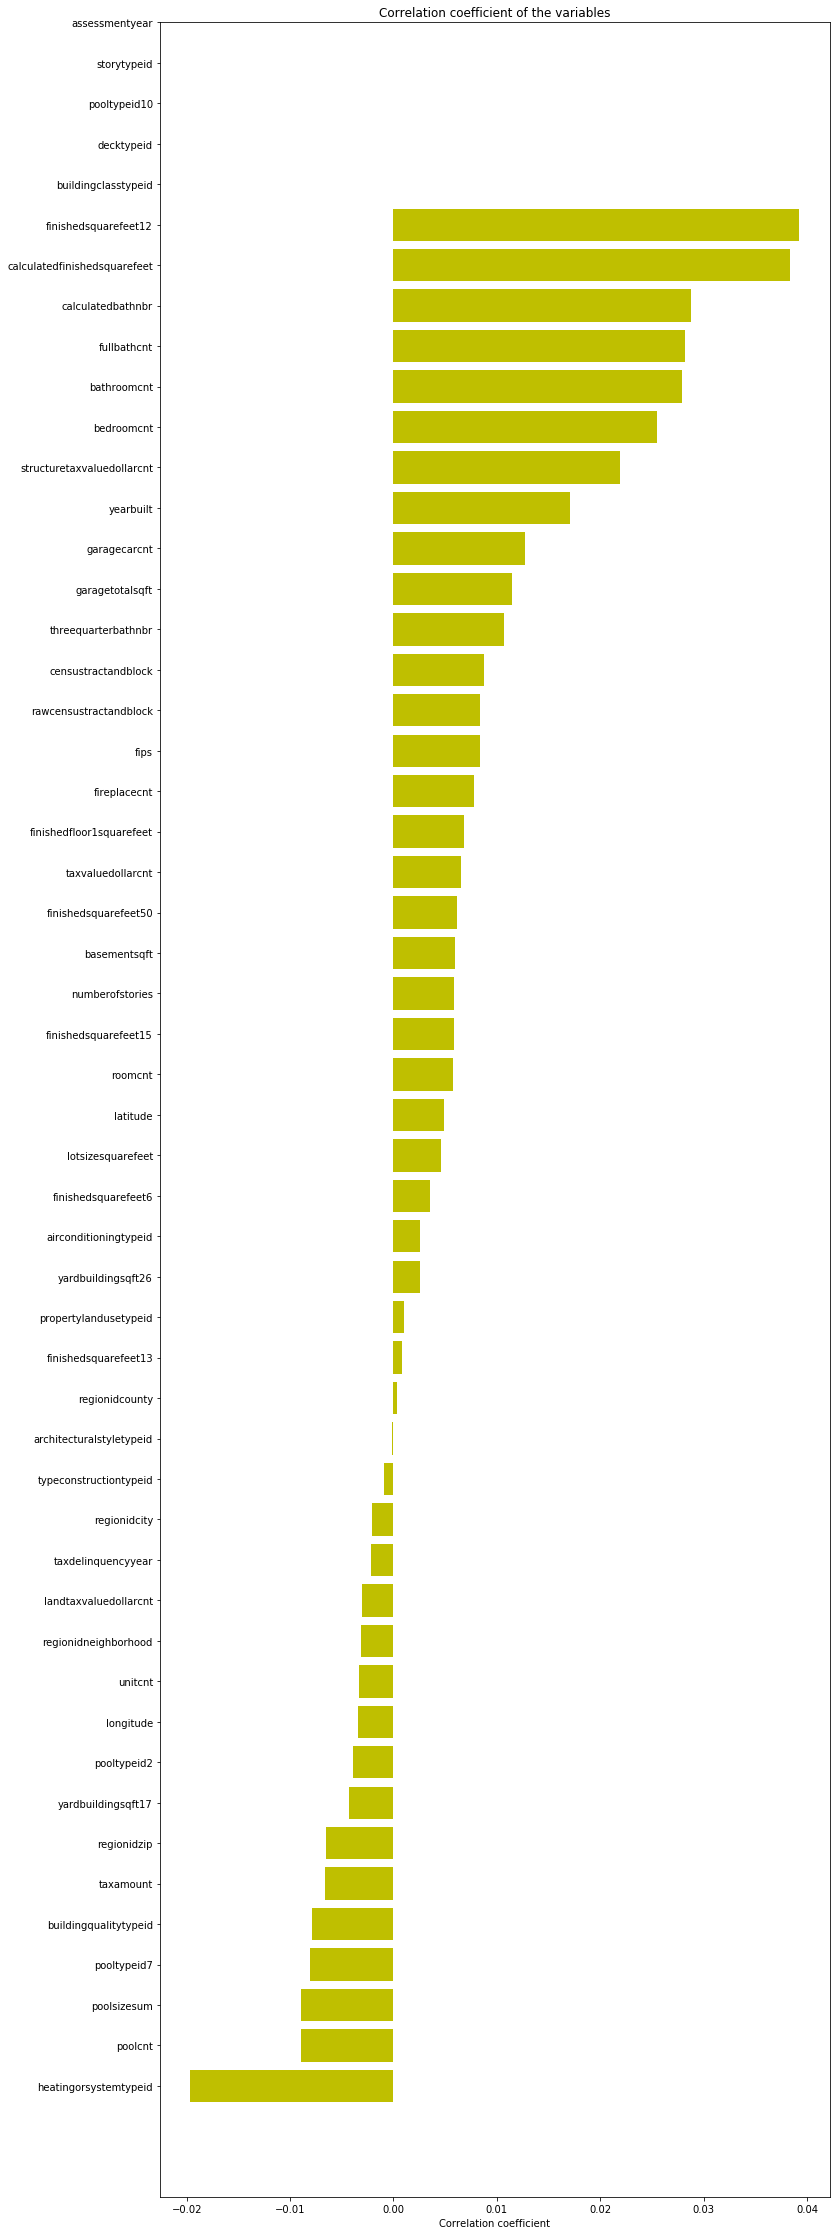

In [24]:
# Let us just impute the missing values with mean values to compute correlation coefficients #
mean_values = train_merge.mean(axis=0)
train_merge_new=train_merge.fillna(mean_values, inplace=True)

x_cols = [col for col in train_merge.columns if col not in ['logerror'] if train_merge[col].dtype=='float32']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_merge[col].values, train_merge.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [25]:
imp_features=corr_df.ix[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
imp_features

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,col_labels,corr_values
21,heatingorsystemtypeid,-0.019648
45,structuretaxvaluedollarcnt,0.021935
4,bedroomcnt,0.025467
3,bathroomcnt,0.027889
18,fullbathcnt,0.028169
7,calculatedbathnbr,0.028758
10,calculatedfinishedsquarefeet,0.038341
11,finishedsquarefeet12,0.039248


,heatingorsystemtypeid,structuretaxvaluedollarcnt,bedroomcnt,bathroomcnt,fullbathcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12
heatingorsystemtypeid,1.000000,-0.157632,-0.129769,-0.249349,-0.273912,-0.257890,-0.189426,-0.197961
structuretaxvaluedollarcnt,-0.157632,1.000000,0.301623,0.581032,0.585495,0.604527,0.709404,0.727240
bedroomcnt,-0.129769,0.301623,1.000000,0.646120,0.585935,0.590046,0.615998,0.560120
bathroomcnt,-0.249349,0.581032,0.646120,1.000000,0.950312,0.965636,0.757887,0.731641
fullbathcnt,-0.273912,0.585495,0.585935,0.950312,1.000000,0.984130,0.774520,0.734254
calculatedbathnbr,-0.257890,0.604527,0.590046,0.965636,0.984130,1.000000,0.795247,0.758692
calculatedfinishedsquarefeet,-0.189426,0.709404,0.615998,0.757887,0.774520,0.795247,1.000000,0.958138
finishedsquarefeet12,-0.197961,0.727240,0.560120,0.731641,0.734254,0.758692,0.958138,1.000000


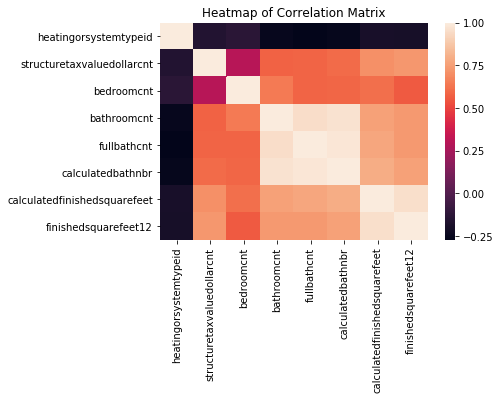

In [26]:
imp_columns = imp_features.col_labels.tolist()
corr_df=train_merge[imp_columns]

corr=corr_df.corr()
corr = (corr)
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

Important variables are highly correlated.

'logerror' is the target variable for our prediction. So lets analyze this.

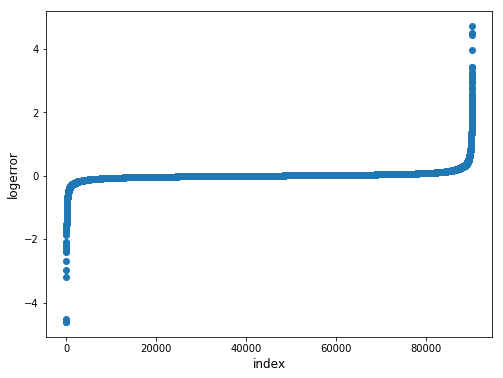

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_merge.shape[0]), np.sort(train_merge.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

Scatter plot for the dependent variable shows there are outliers in the data. Lets plot the histogram to visualize the distribution.

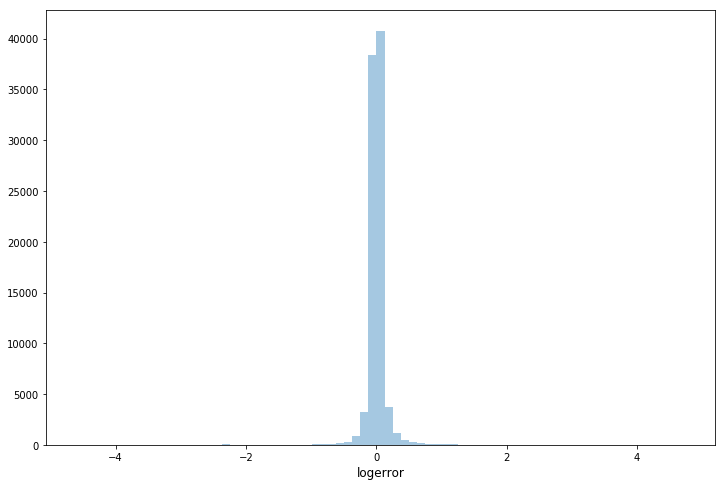

In [28]:

plt.figure(figsize=(12,8))
sns.distplot(train_merge.logerror.values, bins=75, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

'logerror' is normally distributed.

#### Analyzing transactiondate

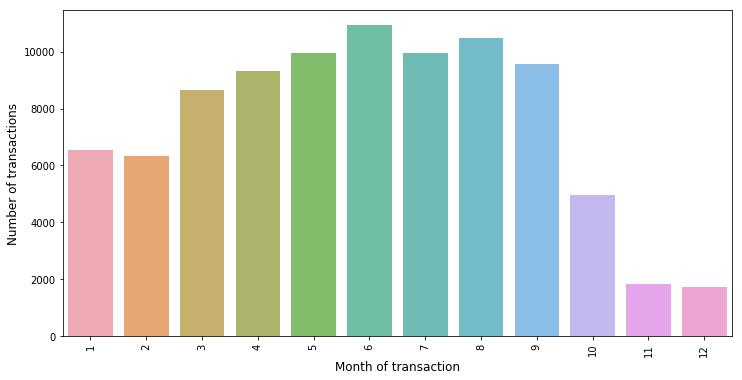

In [29]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  # for ordering in graph , order=month_order
train_month=pd.DataFrame(pd.to_datetime(train_merge['transactiondate']))
train_month['transaction_month'] = train_month["transactiondate"].dt.month
month_df = pd.DataFrame(train_month['transaction_month'].value_counts()).reset_index()
month_df.columns = ['transaction_month', 'count']
plt.figure(figsize=(12,6))
sns.barplot(x='transaction_month', y='count', data=month_df,alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of transactions', fontsize=12)
plt.show()



Most of the data in the train set is before October 15, 2016, which can be seen in the graph as well.

#### Finished SquareFeet 12:

Let us seee how the finished square feet 12 varies with the log error.

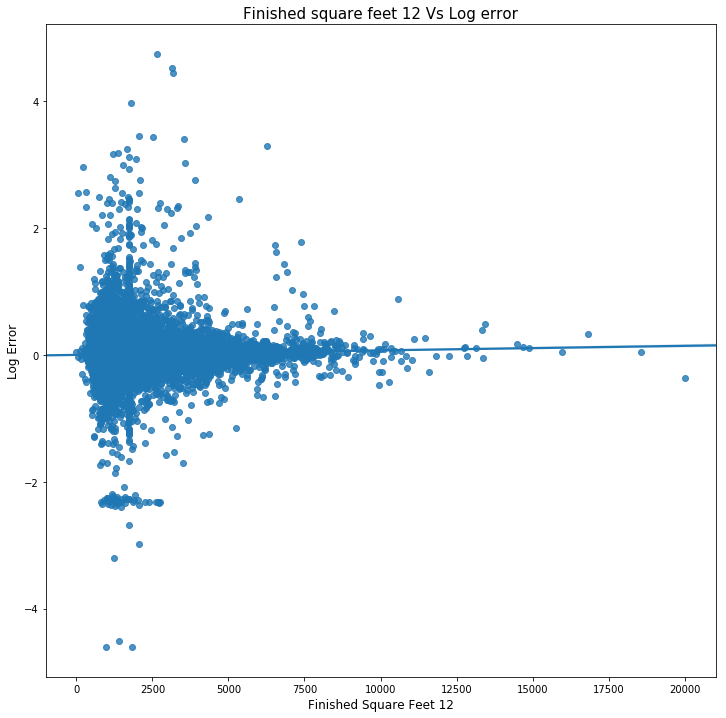

In [30]:
plt.figure(figsize=(12,12))
sns.regplot(x="finishedsquarefeet12", y="logerror", data=train_merge)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Seems the range of logerror narrows down with increase in finished square feet 12 variable.

#### calculatedfinishedsquarefeet

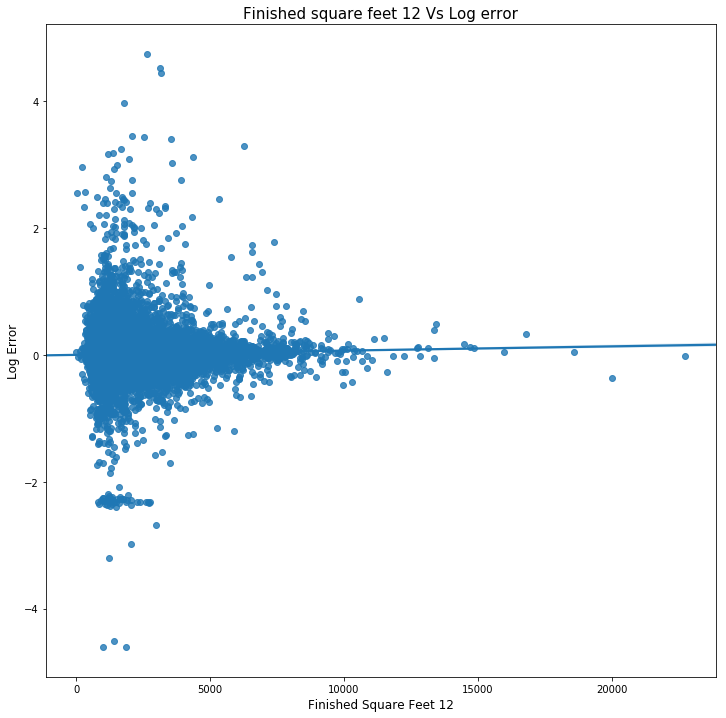

In [31]:
plt.figure(figsize=(12,12))
sns.regplot(x="calculatedfinishedsquarefeet", y="logerror", data=train_merge)
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Finished Square Feet 12', fontsize=12)
plt.title("Finished square feet 12 Vs Log error", fontsize=15)
plt.show()

Above distribution is very similar to the previous one. 

#### calculatedbathnbr

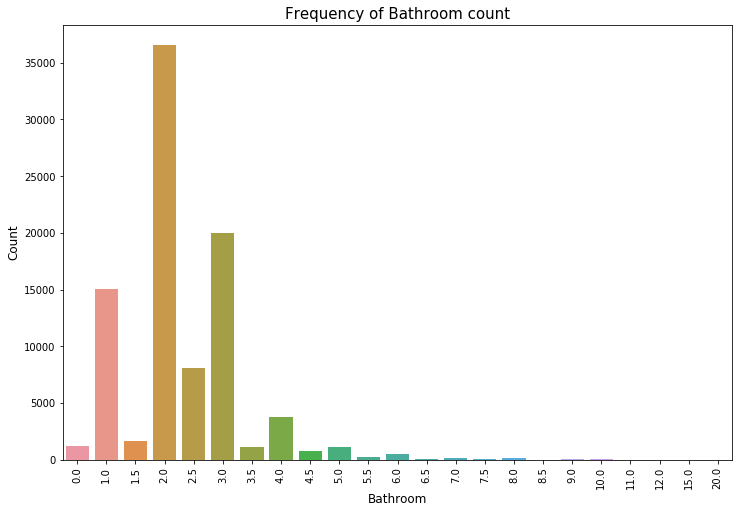

In [32]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=train_merge)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

#### log error changes Vs bathroom count

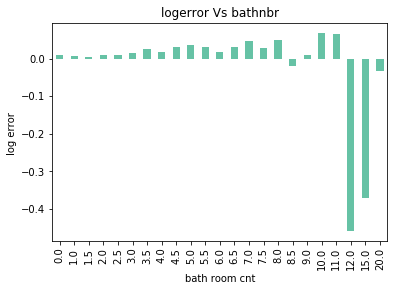

In [33]:
pivot_mean = train_merge.pivot_table(index='bathroomcnt', values='logerror', aggfunc='mean').reset_index()
ax = pivot_mean.plot(x='bathroomcnt', y='logerror',kind='bar',colormap='Set2', title = 'logerror Vs bathnbr', legend=False)
ax.set_xlabel('bath room cnt')
ax.set_ylabel('log error ')
plt.show()

#### bedroomcnt

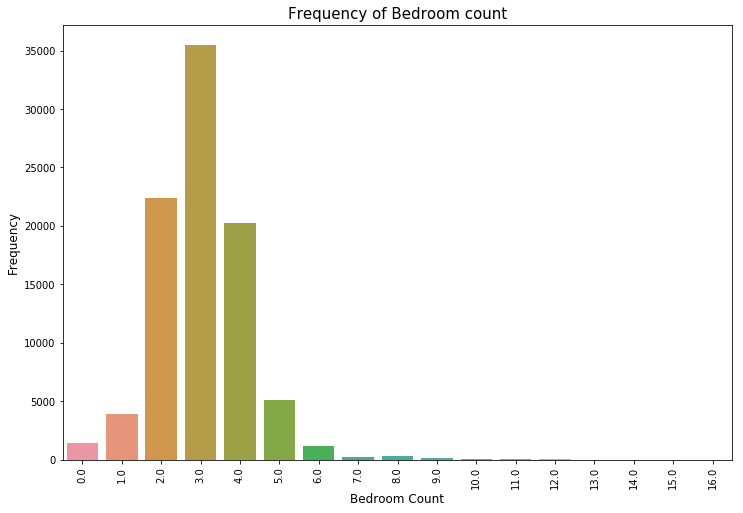

In [34]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=train_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

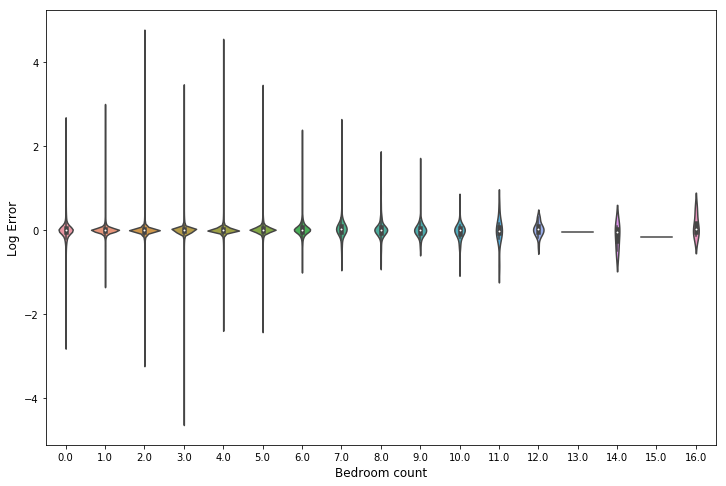

In [35]:

plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=train_merge)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

#### YearBuilt:

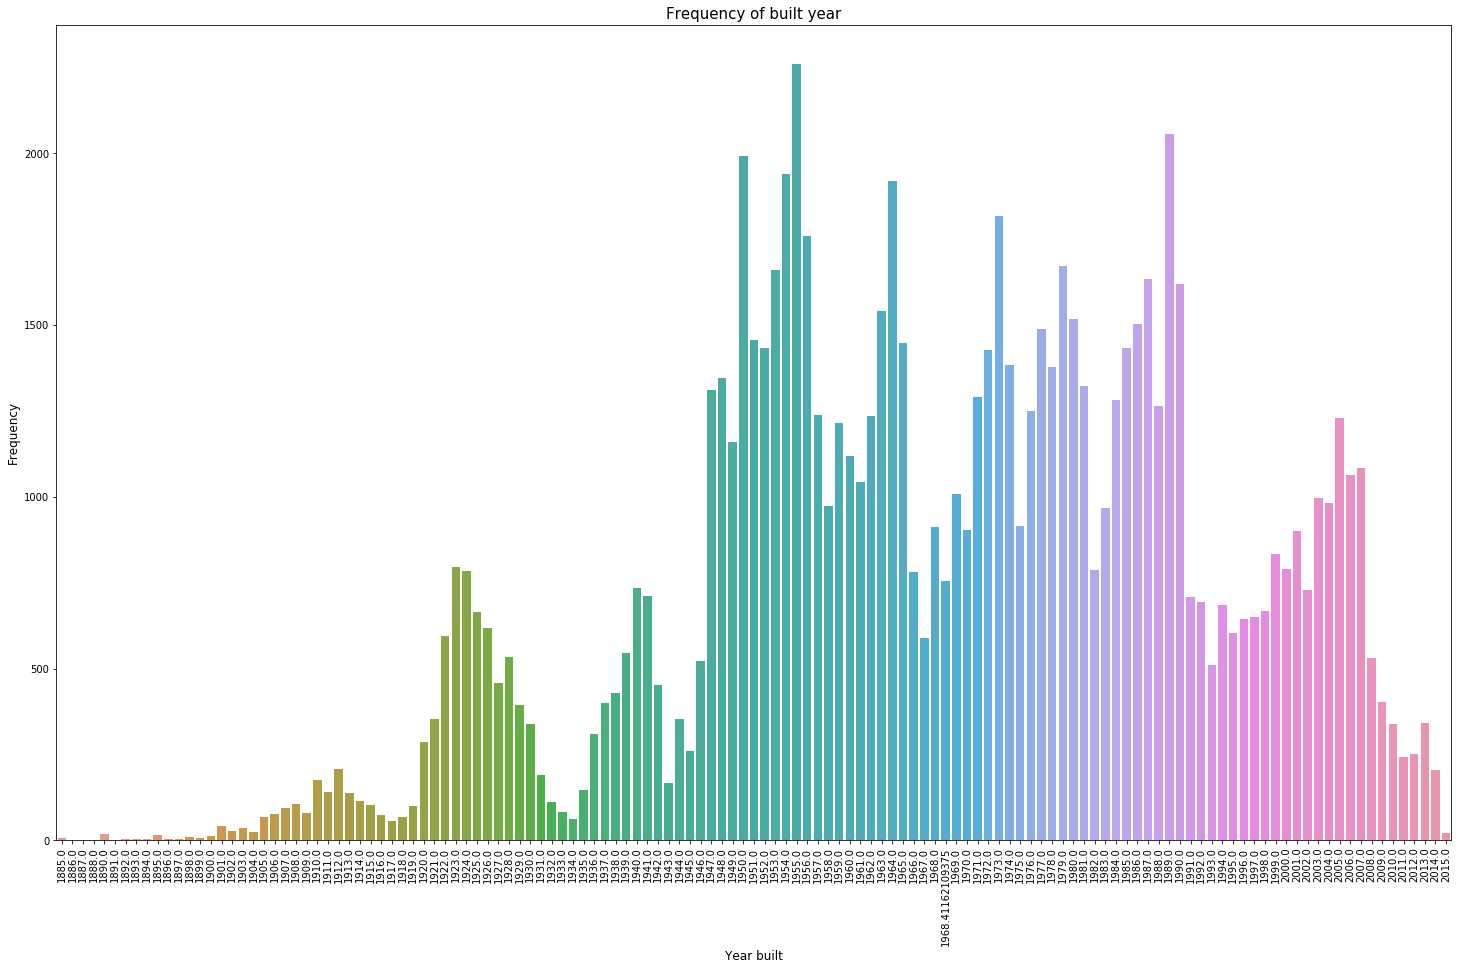

In [36]:
plt.figure(figsize=(25,15))
sns.countplot(x="yearbuilt", data=train_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Year built', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of built year", fontsize=15)
plt.show()


Now lets build a simple linear Regression model to start with.

In [46]:
X_train = train_merge[train_features]
y_train = train_merge.logerror
print(X_train.shape, y_train.shape)

(90275, 41) (90275,)


In [47]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [48]:
#train_columns=train_X.columns
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(properties, on='parcelid', how='left')
x_test = df_test[train_features]


In [49]:
y_test=lm.predict(x_test.fillna(x_test.mean()))
y_test = pd.DataFrame(y_test)
y_test[1] = y_test[0]
y_test[2] = y_test[0]
y_test[3] = y_test[0]
y_test[4] = y_test[0]
y_test[5] = y_test[0] 
y_test.columns = ["201610","201611","201612","201710","201711","201712"]
submission = y_test.copy()
submission["parcelid"] = sample["ParcelId"].copy()
cols = ["parcelid","201610","201611","201612","201710","201711","201712"]
201610, 201611, 201612, 201701, 201702, 201703
submission = submission[cols]
filename = "Prediction_" + str(submission.columns[0]) + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'
print(filename)
submission.to_csv(filename,index=False)

Prediction_parcelid20180802194203201256.csv


### CatBoost

In [44]:
num_ensembles = 5
y_pred = 0.0
for i in range(num_ensembles):
    # TODO(you): Use CV, tune hyperparameters
    model = CatBoostRegressor(
        iterations=200, learning_rate=0.03,
        depth=6, l2_leaf_reg=3,
        loss_function='MAE',
        eval_metric='MAE',
        random_seed=i)
    model.fit(
        X_train, y_train,
        cat_features=cat_feature_inds)
    y_pred += model.predict(x_test)
y_pred /= num_ensembles

0:	learn: 0.0681076	total: 101ms	remaining: 20.2s
1:	learn: 0.0679081	total: 202ms	remaining: 20s
2:	learn: 0.0677807	total: 303ms	remaining: 19.9s
3:	learn: 0.0676982	total: 420ms	remaining: 20.6s
4:	learn: 0.0676399	total: 521ms	remaining: 20.3s
5:	learn: 0.0676043	total: 629ms	remaining: 20.3s
6:	learn: 0.0675541	total: 736ms	remaining: 20.3s
7:	learn: 0.0675173	total: 844ms	remaining: 20.3s
8:	learn: 0.0674879	total: 950ms	remaining: 20.2s
9:	learn: 0.0674588	total: 1.05s	remaining: 20s
10:	learn: 0.0674341	total: 1.16s	remaining: 20s
11:	learn: 0.0674132	total: 1.27s	remaining: 19.8s
12:	learn: 0.0673776	total: 1.37s	remaining: 19.8s
13:	learn: 0.0673571	total: 1.48s	remaining: 19.7s
14:	learn: 0.0673378	total: 1.59s	remaining: 19.6s
15:	learn: 0.0673217	total: 1.7s	remaining: 19.5s
16:	learn: 0.0673075	total: 1.82s	remaining: 19.6s
17:	learn: 0.0672936	total: 1.94s	remaining: 19.6s
18:	learn: 0.0672691	total: 2.05s	remaining: 19.5s
19:	learn: 0.0672557	total: 2.16s	remaining: 19.

162:	learn: 0.0658508	total: 18.7s	remaining: 4.25s
163:	learn: 0.0658433	total: 18.8s	remaining: 4.14s
164:	learn: 0.0658345	total: 19s	remaining: 4.03s
165:	learn: 0.0658263	total: 19.1s	remaining: 3.91s
166:	learn: 0.0658179	total: 19.2s	remaining: 3.8s
167:	learn: 0.0658112	total: 19.3s	remaining: 3.68s
168:	learn: 0.0658031	total: 19.4s	remaining: 3.56s
169:	learn: 0.0657973	total: 19.5s	remaining: 3.44s
170:	learn: 0.0657903	total: 19.6s	remaining: 3.33s
171:	learn: 0.0657857	total: 19.7s	remaining: 3.21s
172:	learn: 0.0657789	total: 19.8s	remaining: 3.09s
173:	learn: 0.0657731	total: 19.9s	remaining: 2.98s
174:	learn: 0.0657680	total: 20s	remaining: 2.86s
175:	learn: 0.0657622	total: 20.1s	remaining: 2.75s
176:	learn: 0.0657528	total: 20.2s	remaining: 2.63s
177:	learn: 0.0657474	total: 20.3s	remaining: 2.52s
178:	learn: 0.0657429	total: 20.4s	remaining: 2.4s
179:	learn: 0.0657366	total: 20.6s	remaining: 2.28s
180:	learn: 0.0657292	total: 20.7s	remaining: 2.17s
181:	learn: 0.0657

123:	learn: 0.0661287	total: 13.6s	remaining: 8.32s
124:	learn: 0.0661213	total: 13.7s	remaining: 8.2s
125:	learn: 0.0661119	total: 13.8s	remaining: 8.09s
126:	learn: 0.0661037	total: 13.9s	remaining: 7.98s
127:	learn: 0.0660979	total: 14s	remaining: 7.87s
128:	learn: 0.0660877	total: 14.1s	remaining: 7.76s
129:	learn: 0.0660783	total: 14.2s	remaining: 7.65s
130:	learn: 0.0660705	total: 14.3s	remaining: 7.54s
131:	learn: 0.0660616	total: 14.4s	remaining: 7.42s
132:	learn: 0.0660515	total: 14.5s	remaining: 7.31s
133:	learn: 0.0660473	total: 14.6s	remaining: 7.2s
134:	learn: 0.0660424	total: 14.7s	remaining: 7.09s
135:	learn: 0.0660302	total: 14.8s	remaining: 6.99s
136:	learn: 0.0660202	total: 15s	remaining: 6.88s
137:	learn: 0.0660139	total: 15.1s	remaining: 6.77s
138:	learn: 0.0660043	total: 15.2s	remaining: 6.65s
139:	learn: 0.0659978	total: 15.3s	remaining: 6.54s
140:	learn: 0.0659900	total: 15.4s	remaining: 6.43s
141:	learn: 0.0659835	total: 15.5s	remaining: 6.32s
142:	learn: 0.0659

85:	learn: 0.0664696	total: 9.05s	remaining: 12s
86:	learn: 0.0664586	total: 9.16s	remaining: 11.9s
87:	learn: 0.0664527	total: 9.27s	remaining: 11.8s
88:	learn: 0.0664432	total: 9.37s	remaining: 11.7s
89:	learn: 0.0664335	total: 9.47s	remaining: 11.6s
90:	learn: 0.0664212	total: 9.58s	remaining: 11.5s
91:	learn: 0.0664077	total: 9.68s	remaining: 11.4s
92:	learn: 0.0663973	total: 9.79s	remaining: 11.3s
93:	learn: 0.0663923	total: 9.89s	remaining: 11.2s
94:	learn: 0.0663831	total: 9.99s	remaining: 11s
95:	learn: 0.0663741	total: 10.1s	remaining: 10.9s
96:	learn: 0.0663646	total: 10.2s	remaining: 10.8s
97:	learn: 0.0663563	total: 10.3s	remaining: 10.7s
98:	learn: 0.0663475	total: 10.4s	remaining: 10.6s
99:	learn: 0.0663419	total: 10.5s	remaining: 10.5s
100:	learn: 0.0663355	total: 10.6s	remaining: 10.4s
101:	learn: 0.0663285	total: 10.7s	remaining: 10.3s
102:	learn: 0.0663228	total: 10.8s	remaining: 10.2s
103:	learn: 0.0663122	total: 10.9s	remaining: 10.1s
104:	learn: 0.0663014	total: 11

45:	learn: 0.0668779	total: 6.01s	remaining: 20.1s
46:	learn: 0.0668629	total: 6.12s	remaining: 19.9s
47:	learn: 0.0668498	total: 6.22s	remaining: 19.7s
48:	learn: 0.0668412	total: 6.33s	remaining: 19.5s
49:	learn: 0.0668299	total: 6.44s	remaining: 19.3s
50:	learn: 0.0668208	total: 6.54s	remaining: 19.1s
51:	learn: 0.0668049	total: 6.65s	remaining: 18.9s
52:	learn: 0.0667925	total: 6.76s	remaining: 18.7s
53:	learn: 0.0667816	total: 6.86s	remaining: 18.5s
54:	learn: 0.0667719	total: 6.96s	remaining: 18.4s
55:	learn: 0.0667584	total: 7.07s	remaining: 18.2s
56:	learn: 0.0667502	total: 7.18s	remaining: 18s
57:	learn: 0.0667384	total: 7.28s	remaining: 17.8s
58:	learn: 0.0667302	total: 7.39s	remaining: 17.7s
59:	learn: 0.0667178	total: 7.5s	remaining: 17.5s
60:	learn: 0.0667060	total: 7.6s	remaining: 17.3s
61:	learn: 0.0666990	total: 7.71s	remaining: 17.2s
62:	learn: 0.0666908	total: 7.82s	remaining: 17s
63:	learn: 0.0666798	total: 7.92s	remaining: 16.8s
64:	learn: 0.0666660	total: 8.03s	rem

5:	learn: 0.0676028	total: 629ms	remaining: 20.4s
6:	learn: 0.0675671	total: 740ms	remaining: 20.4s
7:	learn: 0.0675170	total: 852ms	remaining: 20.4s
8:	learn: 0.0674973	total: 959ms	remaining: 20.3s
9:	learn: 0.0674628	total: 1.07s	remaining: 20.3s
10:	learn: 0.0674310	total: 1.17s	remaining: 20.2s
11:	learn: 0.0674069	total: 1.28s	remaining: 20.1s
12:	learn: 0.0673882	total: 1.39s	remaining: 20s
13:	learn: 0.0673753	total: 1.5s	remaining: 19.9s
14:	learn: 0.0673578	total: 1.6s	remaining: 19.8s
15:	learn: 0.0673356	total: 1.7s	remaining: 19.6s
16:	learn: 0.0673208	total: 1.81s	remaining: 19.5s
17:	learn: 0.0673042	total: 1.92s	remaining: 19.4s
18:	learn: 0.0672889	total: 2.03s	remaining: 19.3s
19:	learn: 0.0672736	total: 2.13s	remaining: 19.2s
20:	learn: 0.0672506	total: 2.24s	remaining: 19.1s
21:	learn: 0.0672327	total: 2.35s	remaining: 19s
22:	learn: 0.0672203	total: 2.45s	remaining: 18.9s
23:	learn: 0.0672026	total: 2.56s	remaining: 18.8s
24:	learn: 0.0671905	total: 2.67s	remaining

166:	learn: 0.0657575	total: 17.9s	remaining: 3.54s
167:	learn: 0.0657526	total: 18s	remaining: 3.43s
168:	learn: 0.0657463	total: 18.1s	remaining: 3.32s
169:	learn: 0.0657395	total: 18.2s	remaining: 3.21s
170:	learn: 0.0657288	total: 18.3s	remaining: 3.11s
171:	learn: 0.0657191	total: 18.4s	remaining: 3s
172:	learn: 0.0657139	total: 18.5s	remaining: 2.89s
173:	learn: 0.0657074	total: 18.6s	remaining: 2.78s
174:	learn: 0.0656998	total: 18.7s	remaining: 2.68s
175:	learn: 0.0656933	total: 18.8s	remaining: 2.57s
176:	learn: 0.0656888	total: 19s	remaining: 2.46s
177:	learn: 0.0656851	total: 19.1s	remaining: 2.36s
178:	learn: 0.0656795	total: 19.2s	remaining: 2.25s
179:	learn: 0.0656737	total: 19.3s	remaining: 2.14s
180:	learn: 0.0656705	total: 19.4s	remaining: 2.04s
181:	learn: 0.0656645	total: 19.5s	remaining: 1.93s
182:	learn: 0.0656585	total: 19.6s	remaining: 1.82s
183:	learn: 0.0656536	total: 19.7s	remaining: 1.71s
184:	learn: 0.0656466	total: 19.8s	remaining: 1.61s
185:	learn: 0.06564

In [54]:
submission = pd.DataFrame({
    'ParcelId': df_test['parcelid'],
})
test_dates = {
    '201610': pd.Timestamp('2016-09-30'),
    '201611': pd.Timestamp('2016-10-31'),
    '201612': pd.Timestamp('2016-11-30'),
    '201710': pd.Timestamp('2017-09-30'),
    '201711': pd.Timestamp('2017-10-31'),
    '201712': pd.Timestamp('2017-11-30')
}
for label, test_date in test_dates.items():
    print("Predicting for: %s ... " % (label))
    submission[label] = y_pred

submission_major = 1
submission.to_csv(
    'submission_%03d.csv' % (submission_major),
    float_format='%.4f',
    index=False)
print("Done! Good luck with submission #%d :)" % submission_major)

Predicting for: 201610 ... 
Predicting for: 201611 ... 
Predicting for: 201612 ... 
Predicting for: 201710 ... 
Predicting for: 201711 ... 
Predicting for: 201712 ... 
Done! Good luck with submission #1 :)
